In [0]:
import os
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Add, Dense, GlobalAveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt

In [2]:
!gdown https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
!unzip Covid_Data_GradientCrescent.zip

Downloading...
From: https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
To: /content/Covid_Data_GradientCrescent.zip
154MB [00:01, 101MB/s] 
Archive:  Covid_Data_GradientCrescent.zip
   creating: all/
   creating: all/test/
   creating: all/test/covid/
  inflating: all/test/covid/nejmoa2001191_f3-PA.jpeg  
  inflating: all/test/covid/nejmoa2001191_f4.jpeg  
  inflating: all/test/covid/nejmoa2001191_f5-PA.jpeg  
  inflating: all/test/covid/radiol.2020200490.fig3.jpeg  
  inflating: all/test/covid/ryct.2020200028.fig1a.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig2.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day0.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day4.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day7.jpeg  
   creating: all/test/normal/
  inflating: all/test/normal/NORMAL2-IM-1385-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1396-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1400-0001.jpeg  
  inflating: all

In [3]:
four_class_train_dir = 'all/train'
os.listdir(four_class_train_dir)

['normal', 'pneumonia_vir', 'pneumonia_bac', 'covid']

In [0]:
image_generator = ImageDataGenerator(rescale = 1./255,
                                     validation_split = 0.1)

In [5]:
train_generator = image_generator.flow_from_directory(batch_size = 20, 
                                                      directory=four_class_train_dir, 
                                                      shuffle= True, 
                                                      target_size=(224,224), 
                                                      class_mode = 'categorical', 
                                                      subset="training")

Found 243 images belonging to 4 classes.


In [6]:
validation_generator = image_generator.flow_from_directory(batch_size = 20, 
                                                           directory= four_class_train_dir, 
                                                           shuffle= True, target_size=(256,256),
                                                           class_mode = 'categorical', 
                                                           subset="validation")

Found 27 images belonging to 4 classes.


In [0]:
class_names = {0: 'Covid-19', 1: 'Normal', 2: 'Bacterial Pneumonia', 3: 'Pneumonia'}

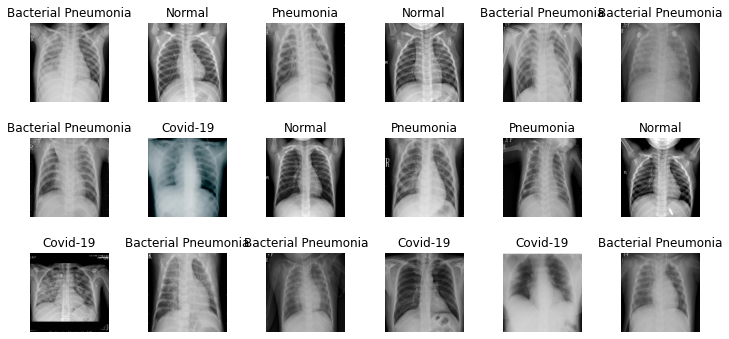

In [8]:
images, labels = next(train_generator)
L = 3
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 6))
axes = axes.ravel()

for i in range(0, L*W):
  axes[i].imshow(images[i])
  axes[i].set_title(class_names[np.argmax(labels[i])])
  axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)  

In [15]:
#Begin the transfer learning

mobile_net = MobileNetV2(weights = 'imagenet',
                         include_top = False,
                         input_shape = (224, 224, 3))

9412608/9406464 [==============================] - 0s 0us/step


In [16]:
mobile_net.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
mobile_net.trainable = False

In [0]:
#Create the head part of the model

head = mobile_net.output
head = GlobalAveragePooling2D()(head)
head = Dense(256, activation = 'relu')(head)
head = Dropout(0.4)(head)
head = Dense(4, activation='softmax')(head)

model = Model(inputs = mobile_net.input, outputs = head)

In [0]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [0]:
#Use early stopping to prevent overfitting
es = EarlyStopping(monitor = 'val_loss',
                   mode = 'min',
                   verbose = 1,
                   patience = 20)

model_saver = ModelCheckpoint(filepath = "covid19.h5", verbose = True, save_best_only = True)

In [23]:
history = model.fit_generator(train_generator,
                             epochs = 20,
                             steps_per_epoch = 1,
                             validation_data = validation_generator,
                             validation_steps = 1,
                             callbacks = [model_saver, es],
                             verbose = 1)

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.8714 - accuracy: 0.6857
Epoch 00001: val_loss did not improve from 0.90622
1/1 [==============================] - 1s 1s/step - loss: 0.8714 - accuracy: 0.6857 - val_loss: 0.9383 - val_accuracy: 0.5185
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 1.1577 - accuracy: 0.6000
Epoch 00002: val_loss improved from 0.90622 to 0.89851, saving model to covid19.h5
1/1 [==============================] - 1s 1s/step - loss: 1.1577 - accuracy: 0.6000 - val_loss: 0.8985 - val_accuracy: 0.5185
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 1.0570 - accuracy: 0.5758
Epoch 00003: val_loss improved from 0.89851 to 0.79568, saving model to covid19.h5
1/1 [==============================] - 2s 2s/step - loss: 1.0570 - accuracy: 0.5758 - val_loss: 0.7957 - val_accuracy: 0.5556
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 0.8640 - accuracy: 0.6286
Epoch 00004: val_loss improved from 0

In [0]:
test_directory = 'all/test'

In [29]:
test_img_generator = ImageDataGenerator(rescale = 1./255)

test_generator = test_img_generator.flow_from_directory(batch_size = 20, 
                                              directory= test_directory, 
                                              shuffle= True,
                                              target_size=(224,224), 
                                              class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, 
                                    steps= test_generator.n // 6,
                                    verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 36 images belonging to 4 classes.
2/6 [=========>....................] - 0s 106ms/step - loss: 0.7991 - accuracy: 0.6667
Accuracy Test : 0.6666666865348816
